In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# Loading the Cifar10 dataset and display examples

(train_ds, test_ds), ds_info  = tfds.load('cifar10', split=['train', 'test'], as_supervised=True,with_info=True)
fig = tfds.show_examples(train_ds, ds_info)

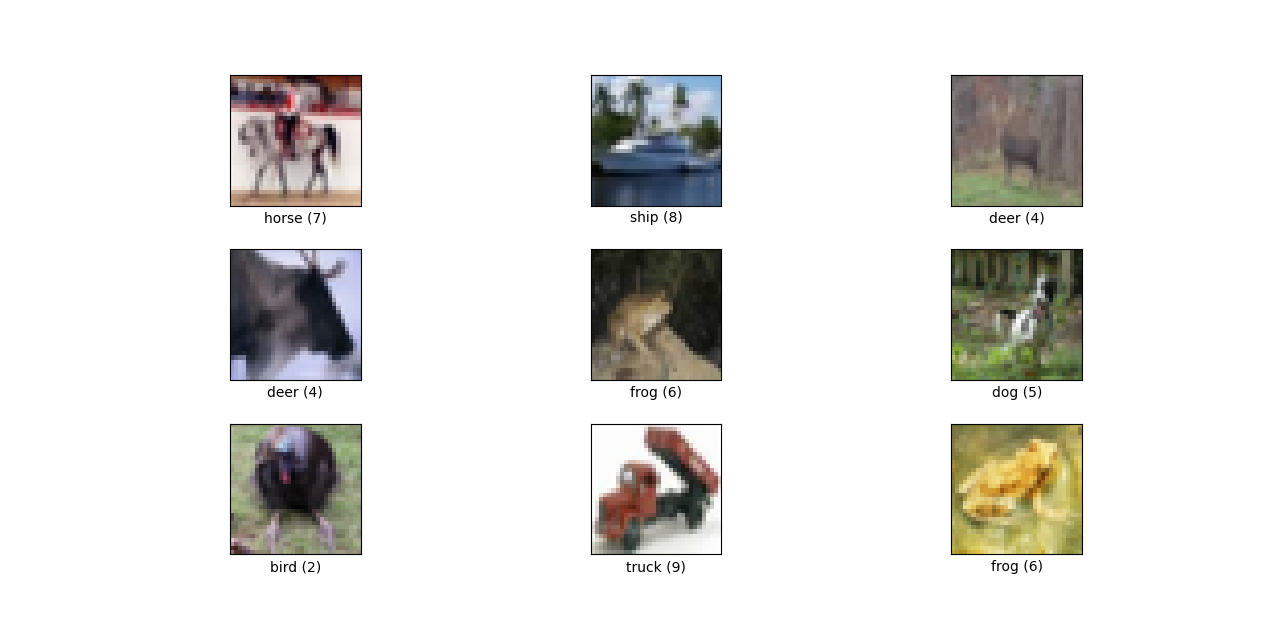

""" Information about the dataset: 

1. Consists of 60000 32x32 colored images in 10 different classes.
2. There are 50000 trainin images and 10000 test images.
3. There are 3 color channels.

"""

In [ ]:
# Data preprocessing

def data_prep (cifar):


    cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # normalizing data
    cifar = cifar.map(lambda img, target: ((img / 128.) - 1., target))
    # one-hot targets, depth=10 we have 10 digits i.e. 10 classes
    cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # cache this progress in memory, as there is no need to redo it; it is deterministic after all
    cifar = cifar.cache()
    # shuffle, batch, prefetch
    cifar = cifar.shuffle(1000)
    cifar = cifar.batch(64)
    cifar = cifar.prefetch(20)

    return cifar


train_dataset = train_ds.apply(data_prep)
test_dataset = test_ds.apply(data_prep)

In [ ]:
# CNN architecture, forward pass

class BasicConv(tf.keras.Model):
    def __init__(self):
        super(BasicConv, self).__init__()

        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()

        self.out = tf.keras.layers.Dense(10, activation='softmax')

    @tf.function
    def call(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x



In [ ]:
# Training loop, accuracy and loss aggregation

def train_model(model, train_dataset, test_dataset, loss_function, optimizer, n_epochs):
    train_loss_final = []
    test_loss_final = []
    train_accuracy_final = []
    test_accuracy_final = []

    for epoch in range(n_epochs):
        train_loss_aggregator = []
        test_loss_aggregator = []
        train_accuracy_aggregator = []
        test_accuracy_aggregator = []

        if epoch >= 1:
            print(f'Epoch: {str(epoch)} >>> test data loss {test_loss_final[-1]}, accuracy {test_accuracy_final[-1]}')

        for input, target in train_dataset:
            with tf.GradientTape() as tape:
                prediction = model(input)
                loss = loss_function(target, prediction)
                train_loss_aggregator.append(loss)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Calculate training accuracy
            predicted_classes = tf.argmax(prediction, axis=1)
            true_classes = tf.argmax(target, axis=1)
            train_accuracy_aggregator.append(tf.reduce_mean(tf.cast(tf.equal(predicted_classes, true_classes), tf.float32)))

        for input, target in test_dataset:
            prediction = model(input)
            sample_test_loss = loss_function(target, prediction)
            test_loss_aggregator.append(sample_test_loss.numpy())

            # Calculate test accuracy
            predicted_classes = tf.argmax(prediction, axis=1)
            true_classes = tf.argmax(target, axis=1)
            test_accuracy_aggregator.append(tf.reduce_mean(tf.cast(tf.equal(predicted_classes, true_classes), tf.float32)))

        # Calculate and append mean accuracy for the epoch
        train_accuracy = tf.reduce_mean(train_accuracy_aggregator)
        test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

        test_loss = tf.reduce_mean(test_loss_aggregator)
        train_loss = tf.reduce_mean(train_loss_aggregator)

        train_loss_final.append(train_loss)
        test_loss_final.append(test_loss)
        train_accuracy_final.append(train_accuracy)
        test_accuracy_final.append(test_accuracy)

    return train_loss_final, test_loss_final, train_accuracy_final, test_accuracy_final

In [ ]:
# Application, Optimizer, Learning rate

tf.keras.backend.clear_session()
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)
model = BasicConv()
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9)
train_loss_final, test_loss_final, train_accuracy_final, test_accuracy_final = train_model(model,train_dataset,test_dataset,cross_entropy_loss,optimizer,20)

In [ ]:
# Visualize loss, accuracy for training and test data

plt.figure()
line1, = plt.plot(train_loss_final)
line2, = plt.plot(test_loss_final)
line3, = plt.plot(train_accuracy_final)
line4, = plt.plot(test_accuracy_final)

plt.xlabel("num of epochs")
plt.ylabel("Metric")
plt.legend((line1, line2, line3, line4), ("train loss", "test loss", "train accuracy", "test accuracy"))
plt.show()

### Setting #9:

self.convlayer1 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.global_pool = tf.keras.layers.GlobalAvgPool2D() 

Lr: 0.001 , Optimizer: Adamax

"""

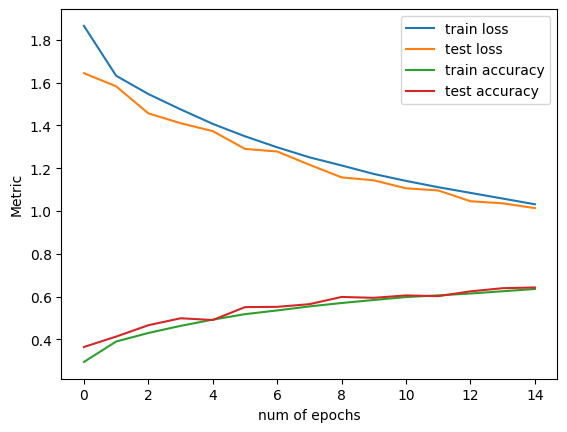

### Setting #8:

self.convlayer1 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.global_pool = tf.keras.layers.GlobalAvgPool2D()

self.out = tf.keras.layers.Dense(10, activation='softmax')

Lr: 0.01 , Optimizer: Adam

"""
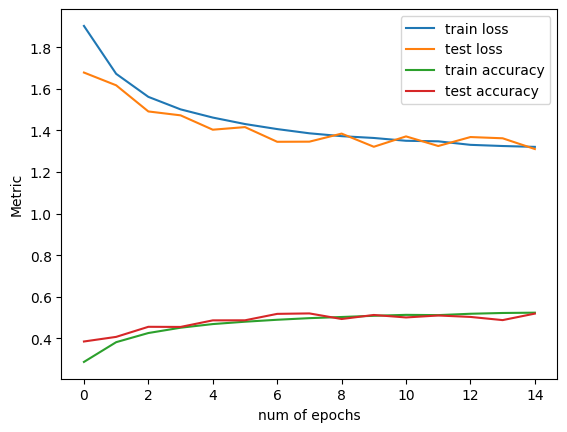

### Setting #7:

self.convlayer1 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.global_pool = tf.keras.layers.GlobalAvgPool2D()

self.out = tf.keras.layers.Dense(10, activation='softmax')

Lr: 0.001 , Optimizer: Adam

"""
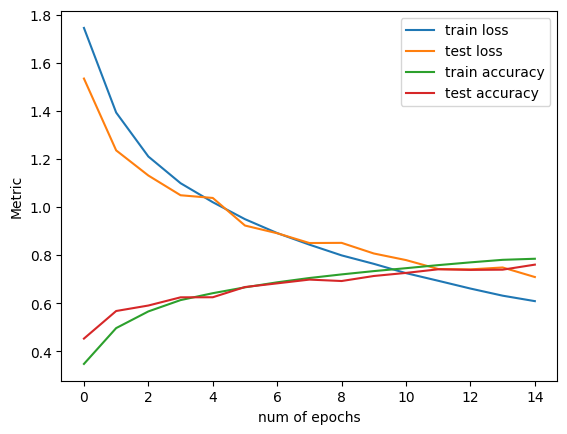

### Setting #6:

self.convlayer1 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.global_pool = tf.keras.layers.GlobalAvgPool2D()

self.out = tf.keras.layers.Dense(10, activation='softmax')

optimizers= SGD(learning_rate=0.001,momentum=0.9)

"""
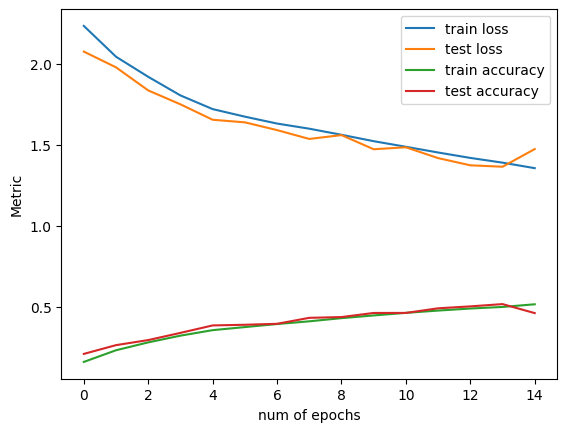

### Setting #5:

self.convlayer1 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer2 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.convlayer5 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.convlayer6 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')

self.global_pool = tf.keras.layers.GlobalAvgPool2D()

self.out = tf.keras.layers.Dense(10, activation='softmax')

Lr: 0.001 , Optimizer: Adam

"""
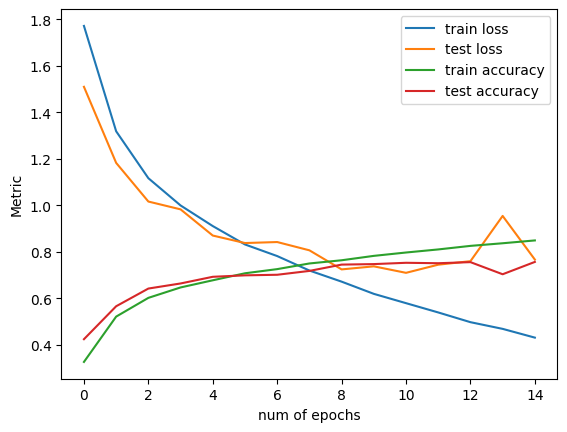

### Setting #4:

self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer3 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer4 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer5 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

self.convlayer6 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer7 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer8 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer9 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer10 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.global_pool = tf.keras.layers.GlobalAvgPool2D()

self.out = tf.keras.layers.Dense(10, activation='softmax')

Lr: 0.001 , Optimizer: Adam

"""
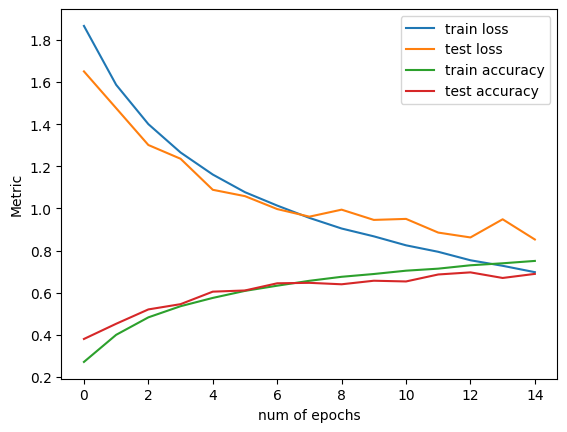

### Setting #3:

self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer3 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer5 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer6 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.global_pool = tf.keras.layers.GlobalAvgPool2D()

self.out = tf.keras.layers.Dense(10, activation='softmax')

Lr: 0.001 , Optimizer: Adam

"""

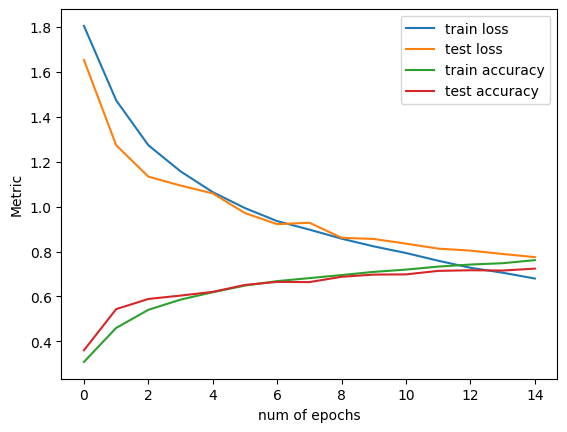

### Setting #2:

self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.global_pool = tf.keras.layers.GlobalAvgPool2D()

self.out = tf.keras.layers.Dense(10, activation='softmax')

Lr: 0.001 , Optimizer: Adam

"""

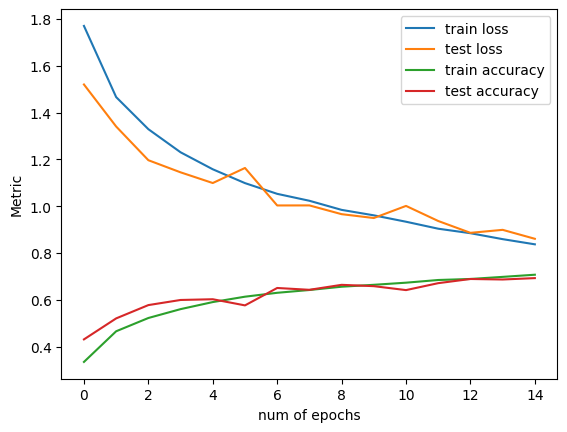

### Setting #1:

self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')

self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')

self.global_pool = tf.keras.layers.GlobalAvgPool2D()

self.out = tf.keras.layers.Dense(10, activation='softmax')

Lr: 0.01 , Optimizer: Adam

"""
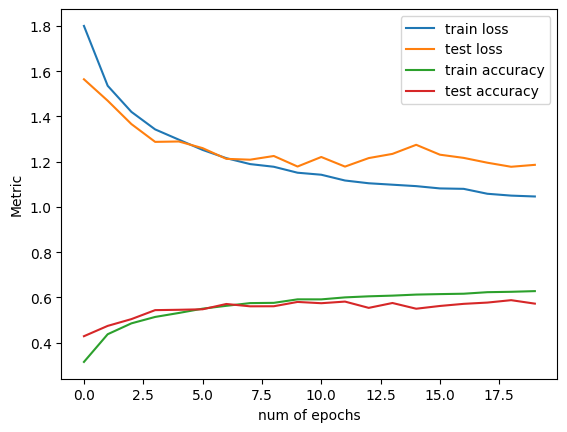
